# Modified LeNet for Traffic Signs

## Load Data

In [1]:
# Load pickled data
import pickle
import tensorflow as tf

training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)

Training Set:   39209 samples
Test Set:       12630 samples


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2, random_state=0)

print("Updated image Shape: {}".format(X_train[0].shape))
print("Updated Training Set:   {} samples".format(len(X_train)))
print("Updated Validation Set:   {} samples".format(len(X_validation)))
print("Updated Test Set:       {} samples".format(len(X_test)))

Updated image Shape: (32, 32, 3)
Updated Training Set:   31367 samples
Updated Validation Set:   7842 samples
Updated Test Set:       12630 samples


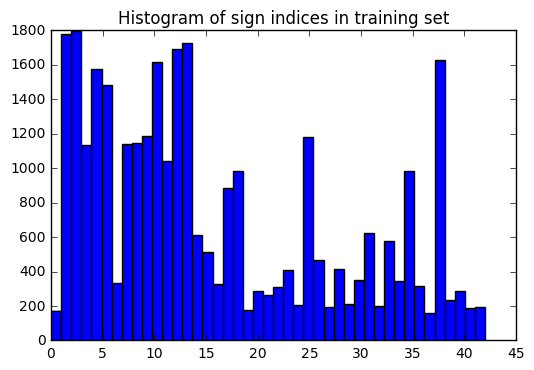

In [3]:
import matplotlib.pyplot as plt
n_classes=43
n,binout,patches = plt.hist(y_train, bins=n_classes)  # plt.hist passes it's arguments to np.histogram
plt.title("Histogram of sign indices in training set")
plt.show()

In [4]:
def random_translate(img):
    rows,cols,_ = img.shape
    
    # allow translation up to px pixels in x and y directions
    px = 2
    dx,dy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    return dst

def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
       
    return dst



def random_scaling(img):   
    rows,cols,_ = img.shape

    # transform limits
    px = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    return dst

In [5]:
import numpy as np
import random
import cv2

def augment_image(X_in, steps):
    # this is a simple function that duplicates the image.  Need to improve this with small shape changes
    retval = np.ndarray((steps, X_in.shape[0], X_in.shape[1], X_in.shape[2]), dtype=np.uint8)
    for step in range(steps):
        #retval[step] = X_in # simply duplicate the image for now
        retval[step] = random_translate(random_scaling(random_warp(X_in)))
    return retval

count = n.size
target_count = 2000 # want at least this many images per class
result = np.ndarray((1,2))
aug_steps = 100 #number of augmentations per image

for index in range(count):
    if (n[index] < target_count):
        #print(index)
        #get all images in this class
        X_source = X_train[y_train==index]
        #repeat (target_count-n[index]) / aug_steps
        for aug_loops in range(int((target_count-n[index]) / aug_steps)):
            #pick a random image from X_source
            class_idx = random.randint(0, X_source.shape[0]-1)
            #reproduce the image aug_steps times
            X_aug = augment_image(X_source[index], aug_steps)
            #append the new images to the X_train
            X_train = np.append(X_train,X_aug, axis=0)
            #append the class data to y_train
            y_train = np.append(y_train, np.repeat(index, aug_steps))
                
print(X_train.shape)
print(y_train.shape)

(83967, 32, 32, 3)
(83967,)


In [6]:
import cv2
import numpy as np

def canny(img, low_threshold = 30, high_threshold = 140):
    """Applies the Canny transform"""
    img = cv2.Canny(img, low_threshold, high_threshold)
    img = np.reshape(img,(32,32,1))
    return img

def preprocess(data):
    """Convert to grayscale, histogram equalize, and expand dims"""
    imgs = np.ndarray((data.shape[0], 32, 32, 3), dtype=np.uint8)
    for i, img in enumerate(data):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.equalizeHist(img)
        img = np.expand_dims(img, axis=2)
        imgs[i] = img
    return imgs

def hisEqulColor(data):
    imgs = np.ndarray((data.shape[0], 32, 32, 3), dtype=np.uint8)
    for i, img in enumerate(data):    
        ycrcb=cv2.cvtColor(img,cv2.COLOR_RGB2YCR_CB)
        channels=cv2.split(ycrcb)
        cv2.equalizeHist(channels[0],channels[0])
        cv2.merge(channels,ycrcb)
        cv2.cvtColor(ycrcb,cv2.COLOR_YCR_CB2RGB,img)
        imgs[i] = img
    return imgs

def NOT_hisEqulColor(data):
    imgs = np.ndarray((data.shape[0], 32, 32, 4), dtype=np.uint8)
    for i, img in enumerate(data):    
        ycrcb=cv2.cvtColor(img,cv2.COLOR_RGB2YCR_CB)
        channels=cv2.split(ycrcb)
        cv2.equalizeHist(channels[0],channels[0])
        cv2.merge(channels,ycrcb)
        cv2.cvtColor(ycrcb,cv2.COLOR_YCR_CB2RGB,img)        

        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)        
        gray_img =  np.reshape(gray_img,(32,32,1))
        cv2.equalizeHist(gray_img,gray_img)   
#        gray_img=canny(gray_img)
#        print(gray_img.shape)
        myvar = np.concatenate((img, gray_img), axis=2)
#        print(myvar.shape)        
    
        imgs[i] = myvar
    return imgs

X_train = NOT_hisEqulColor(X_train)
X_validation = NOT_hisEqulColor(X_validation)
X_test = NOT_hisEqulColor(X_test)

In [7]:
print(X_train.shape)

(83967, 32, 32, 4)


## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

37


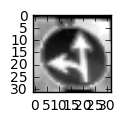

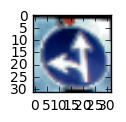

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image[:,:,3], cmap='gray')

plt.figure(figsize=(1,1))
plt.imshow(image[:,:,0:3])

print(y_train[index])

## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [9]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [20]:
import tensorflow as tf

EPOCHS = 15
BATCH_SIZE = 100 #128

In [15]:
from tensorflow.contrib.layers import flatten

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.0, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # A way to get 32x32x1?  **=> Achieved 0.90 accuracy on Validation set <=**
    #C0_W = weight_variable([1,1,3,1])
    #C0_b = bias_variable([1])
    #C0 = conv2d(x, C0_W)+C0_b
    
    # TODO: Layer 1: Convolutional. Input = 32x32x4. Output = 30x30x32.
    # The shape of the filter weight is (height, width, input_depth, output_depth)
    C1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 4, 32), mean=mu, stddev=sigma), name="C1_W")
    C1_b = tf.Variable(tf.zeros(32), name="C1_b") # The shape of the filter bias is (output_depth,)
    C1_strides = [1,1,1,1] # Set the stride for each dimension (batch_size, height, width, depth)
    C1_padding = 'VALID'
    C1 = tf.nn.conv2d(x,
                      C1_W,
                      C1_strides,
                      C1_padding) + C1_b

    # TODO: Activation.
    #C1 = tf.nn.sigmoid(C1)
    C1 = tf.nn.relu(C1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    C1 = tf.nn.avg_pool(C1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #C1 = max_pool_2x2(C1)
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    C2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean=mu, stddev=sigma), name="C2_W")
    C2_b = tf.Variable(tf.zeros(64), name="C2_b") # The shape of the filter bias is (output_depth,)
    C2_strides = [1,1,1,1] # Set the stride for each dimension (batch_size, height, width, depth)
    C2_padding = 'VALID'
    C2 = tf.nn.conv2d(C1,
                      C2_W,
                      C2_strides,
                      C2_padding) + C2_b
    
    # TODO: Activation.
    #C2 = tf.nn.sigmoid(C2)
    C2 = tf.nn.relu(C2)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    C2 = tf.nn.avg_pool(C2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #C2 = max_pool_2x2(C2)
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    C2F = flatten(C2)

    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    FC3_W = tf.Variable(tf.truncated_normal(shape=(1600, 120), mean = mu, stddev = sigma), name="FC3_W")
    FC3_b = tf.Variable(tf.zeros(120), name="FC3_b")
    FC3 = tf.matmul(C2F, FC3_W) + FC3_b
    
    # SOLUTION: Activation.
    #FC3 = tf.nn.sigmoid(FC3)
    FC3 = tf.nn.relu(FC3)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    FC4_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma), name="FC4_W")
    FC4_b  = tf.Variable(tf.zeros(84), name="FC4_b")
    FC4    = tf.matmul(FC3, FC4_W) + FC4_b
    
    # SOLUTION: Activation.
    #FC4    = tf.nn.sigmoid(FC4)
    FC4    = tf.nn.relu(FC4)
    
    #Add DROPOUT
    h_fc1_drop = tf.nn.dropout(FC4, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    FC5_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma), name="FC5_W")
    FC5_b  = tf.Variable(tf.zeros(43), name="FC5_b")
    logits = tf.matmul(h_fc1_drop, FC5_W) + FC5_b

    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [16]:
x = tf.placeholder(tf.float32, (None, 32, 32, 4))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

keep_prob = tf.placeholder(tf.float32)


## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [17]:
rate = 0.001

#global_step = tf.Variable(0, trainable=False)
#starter_learning_rate = 0.001
#learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                           100000, 0.96, staircase=True)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#optimizer = tf.train.AdamOptimizer(learning_rate)
#training_operation = optimizer.minimize(loss_operation, global_step=global_step)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [18]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [19]:
def reportout(s):
    print(s)
    output_f = open('workfile.txt', 'a')
    output_f.write(s)
    output_f.close()
    return
    
with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        
        #print("EPOCH {} ...".format(i+1))
        #print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        #print()
        
        reportout(str("EPOCH {} ...".format(i+1)))
        reportout(str("Validation Accuracy = {:.3f}".format(validation_accuracy)))
        
    saver.save(sess, '.\lenet')
    print("Model saved")

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Training...

EPOCH 1 ...
Validation Accuracy = 0.638
EPOCH 2 ...
Validation Accuracy = 0.819
EPOCH 3 ...
Validation Accuracy = 0.894
EPOCH 4 ...
Validation Accuracy = 0.918
EPOCH 5 ...
Validation Accuracy = 0.940
EPOCH 6 ...
Validation Accuracy = 0.947
EPOCH 7 ...
Validation Accuracy = 0.940
EPOCH 8 ...
Validation Accuracy = 0.959
EPOCH 9 ...
Validation Accuracy = 0.963
EPOCH 10 ...
Validation Accuracy = 0.970
EPOCH 11 ...
Validation Accuracy = 0.970
EPOCH 12 ...
Validation Accuracy = 0.963
EPOCH 13 ...
Validation Accuracy = 0.978
EPOCH 14 ...
Validation Accuracy = 0.974
EPOCH 15 ...
Validation Accuracy = 0.961
EPOCH 16 ...
Validation Accuracy = 0.972
EPOCH 17 ...
Validation Accuracy = 0.974
EPOCH 18 ...
Validation Accuracy = 0.979
EPOCH 19 ...
Validation Accuracy = 0.970
EPOCH 20 ...
Validation Accuracy = 0.979
EPOCH 21 ...
Validation Accuracy = 0.956
EPOCH 22 ...
Validation Accuracy = 0.963
EPOCH 23 ...
Validat

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

In [ ]:
img_count = 38
found_imgs = np.ndarray((img_count,32,32,3), dtype=np.uint8)

for i in range(0,img_count):
    s=str(".\my_data\example_{:05d}.png".format(i+1))
    img = cv2.imread(s)
    found_imgs[i] = img
    
plt.figure(figsize=(1,1))
my_img = found_imgs[0]
plt.imshow(my_img[:,:,0:3])

In [ ]:
y_custom = np.array([
    21, # "example_00001"
    39, # "example_00002"
    17, # "example_00003"
    17, # "example_00004"
    17, # "example_00005"
    39, # "example_00006"
    39, # "example_00007"
    40, # "example_00008"
    40, # "example_00009"
    34, # "example_00010"
    28, # "example_00011"
    39, # "example_00012"
    0, # "example_00013"
    17, # "example_00014"
    38, # "example_00015"
    13, # "example_00016"
    40, # "example_00017"
    13, # "example_00018"
    38, # "example_00019"
    38, # "example_00020"
    11, # "example_00021"
    0, # "example_00022"
    28, # "example_00023"
    0, # "example_00024"
    99, # "example_00025"
    99, # "example_00026"
    99, # "example_00027"
    32, # "example_00028"
    40, # "example_00029"
    28, # "example_00030"
    40, # "example_00031"
    40, # "example_00032"
    28, # "example_00033"
    24, # "example_00034"
    0, # "example_00035"
    0, # "example_00036"
    0, # "example_00037"
    0 # "example_00038"
])

In [ ]:
found_imgs = NOT_hisEqulColor(found_imgs)

print(found_imgs.shape)

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(found_imgs, y_custom)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

In [ ]:
#aug_train = {'features': X_train,
#             'labels': y_train}
found_samples = {'features': found_imgs,
                 'labels': y_custom}

pickle.dump(found_samples, open( './my_data/found.p', 'wb' ) )

print('done')

In [ ]:
# Load pickled data
foundsamples_file = './my_data/found.p'

with open(foundsamples_file, mode='rb') as f:
    train = pickle.load(f)
    
X_found = train['features']
y_found = train['labels']

In [ ]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: X_found, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: X_found, keep_prob: 1.0})

    
    fig, axs = plt.subplots(len(X_found),4, figsize=(12, 14))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(X_found):
        axs[4*i].axis('off')
        #axs[4*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[4*i].imshow(image)
        axs[4*i].set_title('input')
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_validation == guess1)[0]
        axs[4*i+1].axis('off')
        axs[4*i+1].imshow(X_validation[index1].squeeze(), cmap='gray')
        axs[4*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*my_top_k[0][i][0]))
        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(y_validation == guess2)[0]
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(X_validation[index2].squeeze(), cmap='gray')
        axs[4*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*my_top_k[0][i][1]))
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(y_validation == guess3)[0]
        axs[4*i+3].axis('off')
        axs[4*i+3].imshow(X_validation[index3].squeeze(), cmap='gray')
        axs[4*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*my_top_k[0][i][2]))